# NREL - Offshore WA OR - turbine: 25915

## Predicción: h = 1 / H = 24

## Neural Network - LSTM

In [1]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import RenewAI
sys.path.append('/Users/tmorales/tmp/RNN-windPower/src')
from pre_process.split_ml_ts import dataframe_split

In [2]:
exp_path = '/Users/tmorales/tmp/experiments/NREL/Offshore_WA_OR/turbine_25915'
experiment_name = 'nn-lstm_weights-glorot_uniform'
directory = os.path.join(exp_path, experiment_name)
if not os.path.exists(directory):
    os.makedirs(directory)

## Load file

In [3]:
path = '/Users/tmorales/tmp/RNN-windPower/database/wind_farms/Offshore_WA_OR/Offshore_WA_OR_features'

In [4]:
os.chdir(path)
files = [file for file in glob.glob('Offshore_WA_OR_features_*.csv')]
files

['Offshore_WA_OR_features_h_01.csv',
 'Offshore_WA_OR_features_h_02.csv',
 'Offshore_WA_OR_features_h_03.csv',
 'Offshore_WA_OR_features_h_04.csv',
 'Offshore_WA_OR_features_h_05.csv',
 'Offshore_WA_OR_features_h_06.csv',
 'Offshore_WA_OR_features_h_07.csv',
 'Offshore_WA_OR_features_h_08.csv',
 'Offshore_WA_OR_features_h_09.csv',
 'Offshore_WA_OR_features_h_10.csv',
 'Offshore_WA_OR_features_h_11.csv',
 'Offshore_WA_OR_features_h_12.csv',
 'Offshore_WA_OR_features_h_13.csv',
 'Offshore_WA_OR_features_h_14.csv',
 'Offshore_WA_OR_features_h_15.csv',
 'Offshore_WA_OR_features_h_16.csv',
 'Offshore_WA_OR_features_h_17.csv',
 'Offshore_WA_OR_features_h_18.csv',
 'Offshore_WA_OR_features_h_19.csv',
 'Offshore_WA_OR_features_h_20.csv',
 'Offshore_WA_OR_features_h_21.csv',
 'Offshore_WA_OR_features_h_22.csv',
 'Offshore_WA_OR_features_h_23.csv',
 'Offshore_WA_OR_features_h_24.csv']

## Paso 1: only one h-step

In [5]:
h1 = files[0]

In [6]:
# create directory for each horizont (each horizon is a regressor)
horizont = 1
directory_by_horizont = os.path.join(exp_path, 
                                     experiment_name,
                                     'model_saved_h={0:03d}'.format(horizont))
if not os.path.exists(directory_by_horizont):
    os.makedirs(directory_by_horizont)

In [7]:
# load file
df_h1 = pd.read_csv(files[0], delimiter=';', index_col=0)
df_h1.head(4)

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1
target_date,,,,,,,
2004-01-01 06:00:00,6.96,5.28,5.32,4.93,4.05,3.95,4.19
2004-01-01 07:00:00,5.28,5.32,4.93,4.05,3.95,4.19,4.89
2004-01-01 08:00:00,5.32,4.93,4.05,3.95,4.19,4.89,5.16
2004-01-01 09:00:00,4.93,4.05,3.95,4.19,4.89,5.16,5.01


In [8]:
# select the best model for h=1

# split the dataset in train, val and test
data = dataframe_split(df_h1)
train_set = data['train_set']
validation_set = data['validation_set']
test_set = data['test_set']

In [9]:
# features and target columns
features_columns = train_set.columns[1:-1]
target_column = train_set.columns[-1:]

In [10]:
# select the values of features and target columns.
features_train_set = train_set[features_columns]
target_train_set = train_set[target_column]
features_validation_set = validation_set[features_columns]
target_validation_set = validation_set[target_column]
features_test_set = test_set[features_columns]
target_test_set = test_set[target_column]

In [11]:
# select values
x_train = features_train_set.values.astype('float32')
y_train = target_train_set.values
x_val = features_validation_set.values.astype('float32')
y_val = target_validation_set.values

In [12]:
print('N of examples: {0}'.format(x_train.shape))

N of examples: (16830, 5)


In [13]:
x_train.max()

22.25

## Paso 2: Model defenition

In [14]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import TensorBoard

/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
# reshape the data for training LSTM
print(x_train.shape)
x_train_lstm = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train_lstm.shape)

x_val_lstm = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
#x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

(16830, 5)
(16830, 5, 1)


In [16]:
def create_model(time_step, feature_by_timestep,
                 plot_title):
    # Input layer
    input = Input((time_step,
                   feature_by_timestep),
                   dtype='float32',
                   name='input-layer')
    normalize_input = BatchNormalization(name='normalize-input')(input)
    # RNN - LSTM
    x = LSTM(10, 
             kernel_initializer='glorot_uniform',
             name='lstm-layer')(normalize_input)
    # Fully-connect
    x = Dense(10,
              kernel_initializer='normal',
              activation='relu',
              name='hidden-layer-1')(x)
    x = Dense(5, 
              kernel_initializer='normal', 
              activation='relu',
              name='hidden-layer-2')(x)
    x = Dense(3,
              kernel_initializer='normal',
              activation='relu',
              name='hidden-layer-3')(x)
    #x = Dropout(rate=0.2)(x)
    output = Dense(1, 
                   kernel_initializer='normal', 
                   activation='linear',
                   name='output-layer')(x)
    # Model
    model = Model(inputs=input, outputs=output)
    model.summary()
    
    plot_model(model,
               to_file='{0}.png'.format(plot_title),
               show_shapes=True,
               show_layer_names=True,
               rankdir='LR')
    
    return model

In [17]:
def fit_model(model, x_train, y_train, x_val, y_val, exp_path,
              epochs=100, batch_size=50, lr=0.001):
    
    tensorboard = TensorBoard(log_dir=os.path.join(exp_path, 'graph'),
                              histogram_freq=1)
    
    opt = Adam(lr=lr)
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['mae'])
    
    history = model.fit(x_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[tensorboard])
    
    return model, history

In [18]:
model = create_model(5, 1, plot_title='lstm')
model, history = fit_model(model, x_train_lstm, y_train, x_val_lstm, y_val,
                           exp_path=directory, batch_size=1024, epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input-layer (InputLayer)     (None, 5, 1)              0         
_________________________________________________________________
normalize-input (BatchNormal (None, 5, 1)              4         
_________________________________________________________________
lstm-layer (LSTM)            (None, 10)                480       
_________________________________________________________________
hidden-layer-1 (Dense)       (None, 10)                110       
_________________________________________________________________
hidden-layer-2 (Dense)       (None, 5)                 55        
_________________________________________________________________
hidden-layer-3 (Dense)       (None, 3)                 18        
_________________________________________________________________
output-layer (Dense)         (None, 1)                 4         
Total para

Epoch 89/100
16830/16830 [==============================] - 1s 88us/step - loss: 0.8720 - mean_absolute_error: 0.6260 - val_loss: 0.8111 - val_mean_absolute_error: 0.6219
Epoch 90/100
16830/16830 [==============================] - 1s 84us/step - loss: 0.8724 - mean_absolute_error: 0.6250 - val_loss: 0.8153 - val_mean_absolute_error: 0.6236
Epoch 91/100
16830/16830 [==============================] - 1s 85us/step - loss: 0.8631 - mean_absolute_error: 0.6204 - val_loss: 0.8091 - val_mean_absolute_error: 0.6193
Epoch 92/100
16830/16830 [==============================] - 2s 93us/step - loss: 0.8558 - mean_absolute_error: 0.6172 - val_loss: 0.8140 - val_mean_absolute_error: 0.6227
Epoch 93/100
16830/16830 [==============================] - 2s 102us/step - loss: 0.8599 - mean_absolute_error: 0.6182 - val_loss: 0.8092 - val_mean_absolute_error: 0.6194
Epoch 94/100
16830/16830 [==============================] - 2s 91us/step - loss: 0.8796 - mean_absolute_error: 0.6297 - val_loss: 0.8145 - val_m

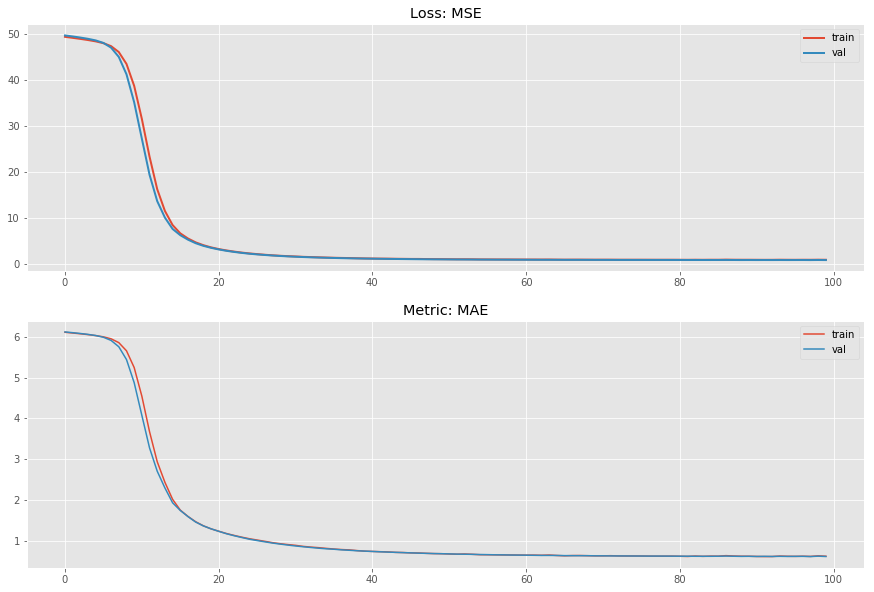

In [19]:
f, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
ax1.plot(history.history['loss'], lw=2, label='train')
ax1.plot(history.history['val_loss'], lw=2, label='val')
ax1.set_title('Loss: MSE')
ax1.legend()
ax2.plot(history.history['mean_absolute_error'], label='train')
ax2.plot(history.history['val_mean_absolute_error'], label='val')
ax2.set_title('Metric: MAE')
ax2.legend()

## Paso 3: Prediction

In [20]:
x_test = features_test_set.values.astype('float32')
x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test_lstm.shape

(5260, 5, 1)

In [21]:
predicted = model.predict(x_test_lstm)

In [22]:
df_prediction = test_set.copy()
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1
target_date,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00


In [23]:
df_prediction = test_set.copy()
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1
target_date,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00


In [24]:
df_prediction['target_predicted'] = predicted
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted
target_date,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.909923
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.349475
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.756500
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.587953
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.531353


In [25]:
# save test dataframe (df_prediction)
filename =  os.path.join(directory, experiment_name)
df_prediction.to_csv('{0}.csv'.format(filename))

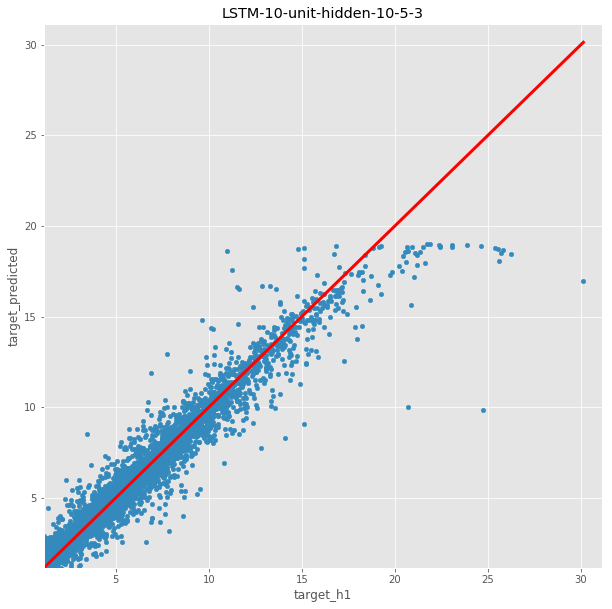

In [26]:
#title='LSTM-10-unit_hidden-5'
title='LSTM-10-unit-hidden-10-5-3'

f, ax = plt.subplots(1,1,figsize=(10,10))
x_min = df_prediction.target_h1.min() 
x_max = df_prediction.target_h1.max()
y_min = df_prediction.target_predicted.min()
y_max = df_prediction.target_predicted.max()
ax.set_title(title)
# line
ax.set_xlim(x_min+1, x_max+1)
ax.set_ylim(x_min+1, x_max+1)
ax.plot((x_min, x_max), (x_min, x_max), lw=3, c='r')
# scatter
df_prediction.plot(ax=ax,
                   x='target_h1',
                   y='target_predicted',
                   kind='scatter',
                  )

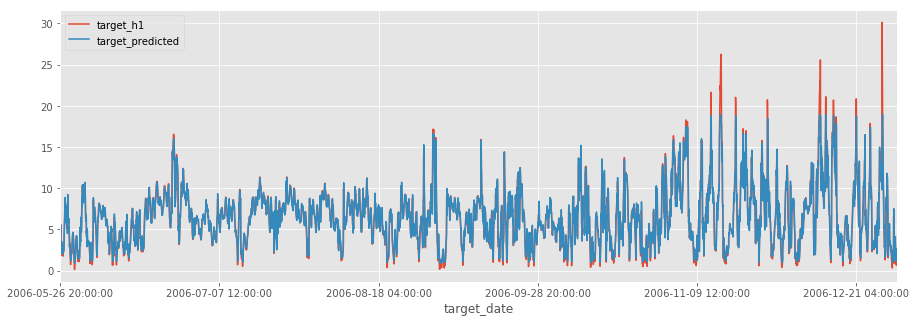

In [27]:
df_prediction.iloc[:,-2:].plot(figsize=(15,5))

In [28]:
 df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted
target_date,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.909923
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.349475
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.756500
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.587953
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.531353


In [86]:
df_prediction['mse_h1'] = np.power(df_prediction.target_h1 -
                                   df_prediction.target_predicted, 2)

In [87]:
df_prediction['mae_h1'] = np.abs(df_prediction.target_h1 - 
                                 df_prediction.target_predicted)

In [88]:
# write on disk
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted,mse_h1,mae_h1
target_date,,,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.855006,0.112221,0.334994
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.308873,0.084755,0.291127
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.743751,0.355513,0.596249
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.585895,0.784810,0.885895
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.516340,2.299286,1.516340


In [89]:
test_mse = df_prediction.mse_h1.sum() / len(df_prediction.mse_h1)
test_mse

0.8332889051709461

In [90]:
test_mae = df_prediction.mae_h1.sum() / len(df_prediction.mae_h1)
test_mae

0.5578560962799384

In [91]:
1/ ( 2*np.sqrt(6/11))

0.67700320038633